PID

In [ ]:
import cv2
import robomaster
from robomaster import robot
from robomaster import vision
from robomaster import blaster
import time
import pandas as pd
import matplotlib.pyplot as plt

# คลาสสำหรับเก็บข้อมูล marker(ป้าย)
class MarkerInfo:
    # ข้อมูลจุดตรงกลางป้าย ความกว้าง ความยาว ข้อมูลป้าย
    def __init__(self, x, y, w, h, info):
        self._x = x
        self._y = y
        self._w = w
        self._h = h
        self._info = info

    # คำนวณมุมซ้ายบนของป้ายและแปลงเป็น pixel
    @property
    def pt1(self):
        return int((self._x - self._w / 2) * 1280), int((self._y - self._h / 2) * 720)

    # คำนวณมุมขวาล่างของป้ายและแปลงเป็น pixel
    @property
    def pt2(self):
        return int((self._x + self._w / 2) * 1280), int((self._y + self._h / 2) * 720)

    # จุดกลางป้ายเป็น pixel
    @property
    def center(self):
        return int(self._x * 1280), int(self._y * 720)

    # ข้อมูลป้าย
    @property
    def text(self):
        return self._info

markers = []

# in case that there are many detected markers
def on_detect_marker(marker_info):
    number = len(marker_info)
    markers.clear()
    for i in range(0, number):
        x, y, w, h, info = marker_info[i]
        markers.append(MarkerInfo(x, y, w, h, info))  # x and y w h is in a range of [0 1] relative to image's size

# เก็บข้อมูลมุมของ gimbal
def sub_data_handler(angle_info):
    global list_of_data
    list_of_data = angle_info

if __name__ == "__main__":
    # initialize robot
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")
    ep_vision = ep_robot.vision
    ep_camera = ep_robot.camera
    ep_gimbal = ep_robot.gimbal
    ep_blaster = ep_robot.blaster

    # the image center constants
    center_x = 1280 / 2
    center_y = 720 / 2

    ep_camera.start_video_stream(display=False)
    ep_gimbal.sub_angle(freq=20, callback=sub_data_handler)
    result = ep_vision.sub_detect_info(name="marker", callback=on_detect_marker)

    # หมุน gimbal กลับไปที่ center
    ep_gimbal.recenter(pitch_speed=200, yaw_speed=200).wait_for_completed()

    count = 0
    shoot = True
    count_shoot = 0
    time.sleep(1)

    # PID controller constants
    p = 0.4705
    i = 1.1527
    d = 0.0480
    
    # ku = 1.4
    # pu = 18.9

    # kc = ku / 1.7
    # ti = pu / 2
    # td = pu / 8

    # p = kc
    # i = kc / ti
    # d = kc * td

    prev_err_x = 0.0
    prev_err_y = 0.0
    prev_time = time.time()

    accumulate_err_x = 0
    accumulate_err_y = 0

    data_pith_yaw = []

    # loop การทำงานของหุ่น
    while True:
        if len(markers) != 0:  # target found
            after_time = time.time()
            x, y = markers[-1].center  # x,y here in the pixel unit

            err_x = center_x - x  # err_x = image_center in x direction - current marker center in x direction
            err_y = center_y - y  # err_y = image_center in y direction - current marker center in y direction

            accumulate_err_x += err_x
            accumulate_err_y += err_y

            if count >= 1:
                # คำนวณความเร็วในการหมุน gimbal โดยใช้ PID
                speed_x = (
                    (p * err_x)
                    + d * ((err_x - prev_err_x) / (after_time - prev_time))
                    + i * (accumulate_err_x) * (after_time - prev_time)
                )
                speed_y = (
                    (p * err_y)
                    + d * ((err_y - prev_err_y) / (after_time - prev_time))
                    + i * (accumulate_err_y) * (after_time - prev_time)
                )

                # หมุน gimbal ตามความเร็วที่คำนวณมาก
                ep_gimbal.drive_speed(pitch_speed=speed_y, yaw_speed=-speed_x)

                # เก็บค่ามุมของ gimbal, error x, error y, speed x, speed y
                data_pith_yaw.append(
                    list(list_of_data) + [err_x, err_y, round(speed_x, 3), round(speed_y, 3)] + [x, y]
                )

            # Firing the blaster when error is low
           
            # if count % 50 == 0:
            #     if shoot:
            #         shoot = False
            #     else:
            #         shoot = True
            #     print(count, shoot)

            # if shoot and abs(err_x) < 10 and abs(err_y) <10 :
            #     ep_blaster.fire(times=1)
            #     count_shoot += 1
            #     shoot = False
            # print(err_x,err_y)

            
            count += 1

            prev_err_x = err_x
            prev_err_y = err_y
            prev_time = after_time
            
            time.sleep(0.001)

        else:
            # หมุนกลับ center
            ep_gimbal.drive_speed(pitch_speed=0, yaw_speed=0)

        # อ่านภาพ
        img = ep_camera.read_cv2_image(strategy="newest", timeout=0.5)

        # วาดสี่เหลี่ยมบนภาพในตำแหน่งที่เจอป้าย
        for j in range(0, len(markers)):
            cv2.rectangle(img, markers[j].pt1, markers[j].pt2, (0, 255, 0))
            # cv2.putText(
            #     img,
            #     markers[j].text,
            #     markers[j].center,
            #     cv2.FONT_HERSHEY_SIMPLEX,
            #     1.5,
            #     (0, 255, 0),
            #     3,
            # )
        # แสดงภาพ
        cv2.imshow("Markers", img)
        # สำหรับออกจาก loop while
        if cv2.waitKey(1) & 0xFF == ord("q"):
            print(count_shoot)
            break

    cv2.destroyAllWindows()

    result = ep_vision.unsub_detect_info(name="marker")
    ep_camera.stop_video_stream()
    ep_robot.close()

    # print('length data_pitch_raw :', len(data_pith_yaw))
    # plot error x, error y, speed x, speed y
    x_point = [i for i in range(len(data_pith_yaw))]
    y_point4 = [i[4] for i in data_pith_yaw]
    y_point5 = [i[5] for i in data_pith_yaw]
    y_point6 = [i[6] for i in data_pith_yaw]
    y_point7 = [i[7] for i in data_pith_yaw]
    y_point8 = [i[8] for i in data_pith_yaw]  # x
    y_point9 = [i[9] for i in data_pith_yaw]  # y
    # print("err_x =", y_point4)
    plt.plot(x_point, y_point4)

    plt.legend(["gimbal"])
    plt.show()








imgae processing

In [1]:
import cv2
import numpy as np
from scipy.spatial.distance import cosine

lst_score = []
count_f = 0

class CokeCanMarker:
    def __init__(self, x, y, w, h, score):
        self._x = x
        self._y = y
        self._w = w
        self._h = h
        self._score = score

    @property
    def pt1(self):
        return int(self._x), int(self._y)

    @property
    def pt2(self):
        return int(self._x + self._w), int(self._y + self._h)

    @property
    def center(self):
        return int(self._x + self._w / 2), int(self._y + self._h / 2)

    @property
    def text(self):
        return f"Score: {self._score:.2f}"

def detect_coke_can(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)
    
    # Added sizes of anchor boxes
    anchor_boxes = [(25, 65), (50, 130), (100, 260)]
    best_score = -1
    best_box = None
    stride = 20  # Define the stride for sliding window
    
    # Loop through each anchor box size
    for (box_w, box_h) in anchor_boxes:
        for y in range(0, mask.shape[0] - box_h, stride):
            for x in range(0, mask.shape[1] - box_w, stride):
                window = mask[y:y+box_h, x:x+box_w]
                window_vector = window.flatten()
                target_vector = np.ones_like(window_vector)
                
                window_norm = np.linalg.norm(window_vector)
                target_norm = np.linalg.norm(target_vector)
                if window_norm == 0 or target_norm == 0:
                    continue
                
                similarity = 1 - cosine(window_vector / window_norm, target_vector / target_norm)
                
                # Condition for the best score selection
                if 0.72 < similarity < 0.85 and similarity > best_score:
                    best_score = similarity
                    best_box = (x, y, box_w, box_h)
                    
    lst_score.append(best_score)

    if best_box:
        x, y, box_w, box_h = best_box
        cv2.rectangle(image, (x, y), (x + box_w, y + box_h), (0, 255, 0), 2)
        return CokeCanMarker(x, y, box_w, box_h, best_score), best_score

    return None, None

def main():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        coke_can_marker, score = detect_coke_can(frame)
        if coke_can_marker:
            cv2.putText(frame, coke_can_marker.text, coke_can_marker.pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        cv2.imshow('Coke Can Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()



full

1
2
3
4
5
6
7
8
0.4150687609820077
9
10
11
12
13
14
15


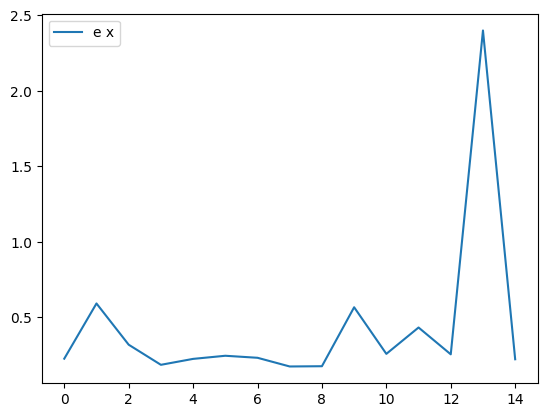

<Figure size 640x480 with 0 Axes>

In [6]:
import cv2
import robomaster
from robomaster import robot
from robomaster import vision
from robomaster import blaster
import time
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

## 7.2 -7.8
lst_score = []
count_f = 0

class CokeCanMarker:
    def __init__(self, x, y, w, h, score):
        self._x = x
        self._y = y
        self._w = w
        self._h = h
        self._score = score

    @property
    def pt1(self):
        return int(self._x), int(self._y)

    @property
    def pt2(self):
        return int(self._x + self._w), int(self._y + self._h)

    @property
    def center(self):
        return int(self._x + self._w / 2), int(self._y + self._h / 2)

    @property
    def text(self):
        return f"Score: {self._score:.2f}"

def detect_coke_can(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)
    
    anchor_boxes = [(30, 70)]
    best_score = -1
    best_box = None
    stride = 20
    
    for (box_w, box_h) in anchor_boxes:
        for y in range(0, mask.shape[0] - box_h, stride):
            for x in range(0, mask.shape[1] - box_w, stride):
                window = mask[y:y+box_h, x:x+box_w]
                window_vector = window.flatten()
                target_vector = np.ones_like(window_vector)
                
                window_norm = np.linalg.norm(window_vector)
                target_norm = np.linalg.norm(target_vector)
                if window_norm == 0 or target_norm == 0:
                    continue
                
                similarity = 1 - cosine(window_vector / window_norm, target_vector / target_norm)
                
                if 0.72 < similarity < 0.85 and similarity > best_score:
                    best_score = similarity
                    best_box = (x, y, box_w, box_h)
                    
    lst_score.append(best_score)

    if best_box:
        x, y, box_w, box_h = best_box
        cv2.rectangle(image, (x, y), (x + box_w, y + box_h), (0, 255, 0), 2)
        return CokeCanMarker(x, y, box_w, box_h, best_score), best_score

    return None, None


if __name__ == "__main__":
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")
    ep_blaster = ep_robot.blaster
    ep_camera = ep_robot.camera
    ep_gimbal = ep_robot.gimbal

    center_x = 1280 / 2
    center_y = 720 / 2
    ep_camera.start_video_stream(display=False)
    ep_gimbal.sub_angle(freq=10)
    ep_gimbal.recenter(pitch_speed=200, yaw_speed=200).wait_for_completed()
    time.sleep(1)

    p = 0.485
    i = 1.125
    d = 0.0485
    
    boom = True

    accumulate_err_x = 0
    accumulate_err_y = 0
    data_pith_yaw = []
    prev_time = time.time()
    prev_err_x = 0
    prev_err_y = 0
    
    while True:
        img = ep_camera.read_cv2_image(strategy="newest", timeout=0.5)
        marker,score = detect_coke_can(img)

        if marker:
            after_time = time.time()
            x, y = marker.center

            err_x = center_x - x
            err_y = center_y - y
            accumulate_err_x += err_x * (after_time - prev_time)
            accumulate_err_y += err_y * (after_time - prev_time)

            if score >= 0.72:
                count_f+=1
                print(count_f)
                if count_f == 20 :
                    ep_blaster.fire(fire_type=blaster.INFRARED_FIRE, times=1)
                    count_f=0

            speed_x = p * err_x
            speed_y = p * err_y
            ep_gimbal.drive_speed(pitch_speed=speed_y, yaw_speed=-speed_x)

            data_pith_yaw.append([err_x, err_y, round(speed_x, 3), round(speed_y, 3), after_time - prev_time])

            prev_time = after_time
            prev_err_x = err_x
            prev_err_y = err_y

            cv2.rectangle(img, marker.pt1, marker.pt2, (0, 255, 0), 2)
            cv2.putText(img, marker.text, marker.center, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            time.sleep(0.001)

            if len(lst_score) == 10 :
                result = sum(lst_score) / len(lst_score)
                print(result)
                lst_score = []

        else:
            ep_gimbal.drive_speed(pitch_speed=0, yaw_speed=0)

        cv2.imshow("Coke Can Detection", img)
        


        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cv2.destroyAllWindows()
    ep_camera.stop_video_stream()
    ep_robot.close()

    x_point = [i for i in range(len(data_pith_yaw))]
    y_point4 = [i[4] for i in data_pith_yaw]


    plt.plot(x_point, y_point4)
    plt.legend(["e x", "e y", "u x", "u y"])
    plt.show()
    plt.savefig("graph.png")